# 🎨 Part 2: Guided Generation and Control in Pretrained Diffusion Models

### Name: Shahreyar Ashraf
### Roll number: 26100342

## 🚀 Objectives:
- Use pretrained **Stable Diffusion** for text-to-image generation
- Experiment with **guidance scales** and **prompt engineering**
- Explore **inpainting**
- Explore **Style Transfer**

---

## 🧰 Setup

> Run the cell below to install the necessary libraries: `diffusers`, `transformers`, `accelerate`, `safetensors`, `xformers`, and `controlnet_aux`.

These libraries will enable us to use pre-trained diffusion models and speed up inference using GPU acceleration.



In [1]:
!pip install --upgrade diffusers transformers accelerate safetensors xformers controlnet_aux --quiet



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

# 🧪 Task 1: Classifier-Free Guidance in Stable Diffusion

In diffusion-based generative models, **Classifier-Free Guidance (CFG)** is a technique used to steer the generation process toward better image-text alignment without requiring an external classifier.

Here's how it works:
- During training, the model occasionally replaces the text condition with an empty string (i.e., unconditional).
- At inference time, it combines the conditional and unconditional predictions to guide the sample.
  
The guidance formula is:\
prediction = uncond + scale * (cond - uncond)


Where:
- `cond` is the model's prediction with the prompt.
- `uncond` is the model's prediction without the prompt.
- `scale` (a float) controls the strength of the guidance.

A higher `guidance_scale` encourages the model to follow the prompt more closely, possibly at the cost of image diversity.




In [2]:
from diffusers import StableDiffusionPipeline, StableDiffusionInpaintPipeline, StableDiffusionImg2ImgPipeline
import torch
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

device = "cuda" if torch.cuda.is_available() else "cpu"


### ⚙️ Step 1: Load a Pretrained Stable Diffusion Model

Use `diffusers` from HuggingFace to load a pretrained Stable Diffusion pipeline.

📌 Your task:
- Load the `"runwayml/stable-diffusion-v1-5"` model.
- Set the pipeline to use `torch_dtype=torch.float16`.
- Move the model to `"cuda"` and enable attention slicing for memory efficiency.

### 🎛️ Step 2: Implement CFG Sampling

Define a function that:
- Takes a prompt and a guidance scale.
- Uses the pipeline to generate an image with the given CFG value.
- Returns the generated image.

📌 This is your **CFG sampler**.


In [2]:
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
)
pipe = pipe.to("cuda")
pipe.enable_attention_slicing()


def cfg_sampler(prompt: str,
                guidance_scale: float,
                num_inference_steps: int = 50,
                seed: int = None):
    """
    Generate an image with classifier-free guidance.

    Args:
        prompt (str): The text prompt to condition on.
        guidance_scale (float): CFG scale (uncond + scale * (cond - uncond)).
        num_inference_steps (int): Number of diffusion steps.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        PIL.Image: The generated image.
    """
    generator = None
    if seed is not None:
        generator = torch.Generator(device="cuda").manual_seed(seed)

    output = pipe(
        prompt=prompt,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        generator=generator,
    )
    return output.images[0]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### 🧪 Step 3: Analyze the Effect of CFG

Use your `generate_with_cfg` function to generate images for the same prompt with **different guidance scales**.

- Prompt: `"a futuristic cityscape at night"`
- Try values of `guidance_scale`: `[1.0, 5.0, 7.5, 12.0]`
- Try a prompt by yourself too

🎨 Display the results in a horizontal row of subplots.
- Add titles showing the CFG scale.
- Hide the axes.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

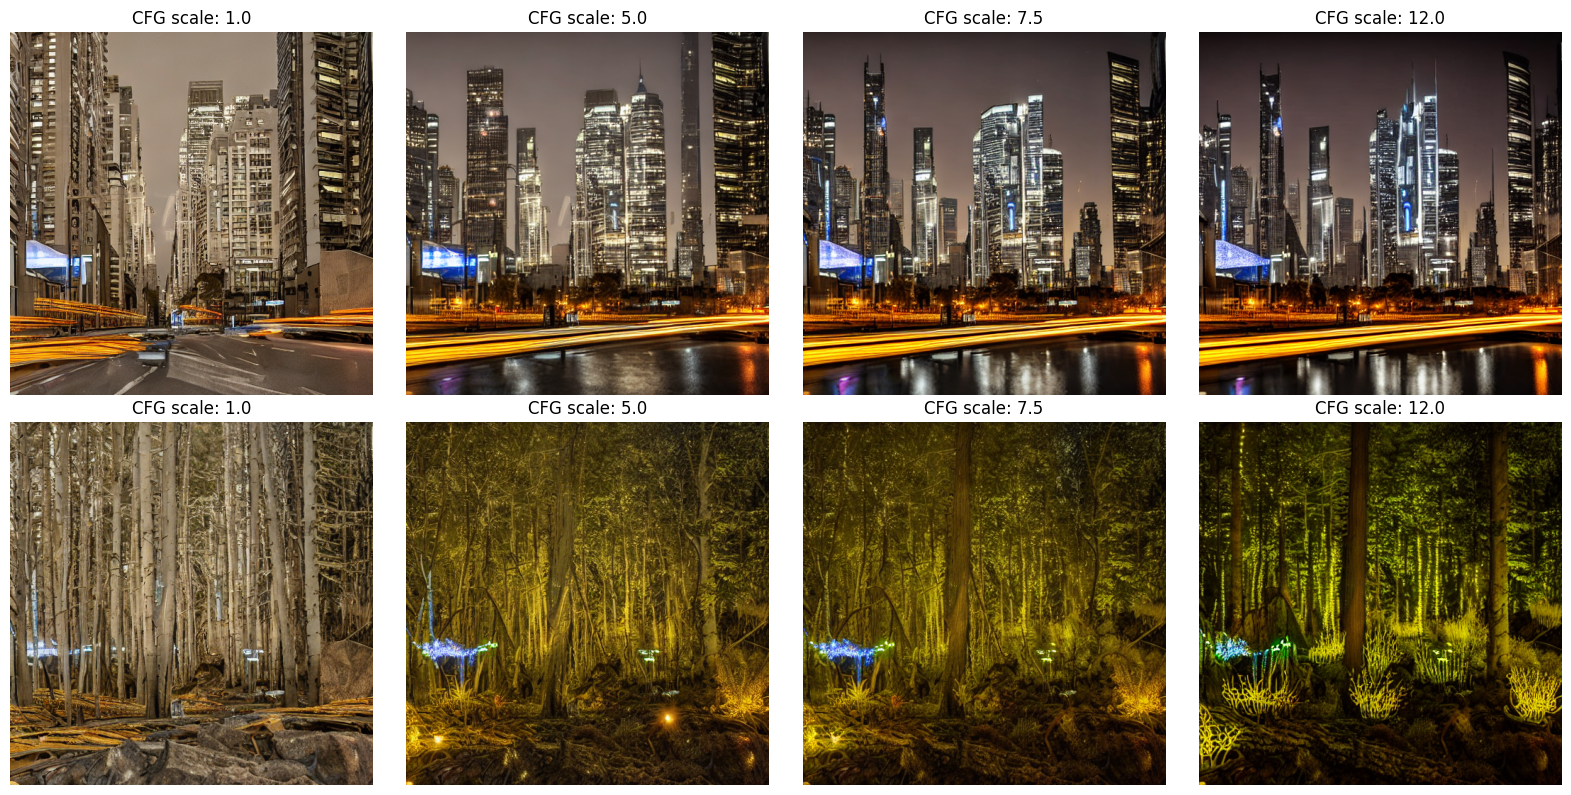

In [ ]:
prompts = [
    "a futuristic cityscape at night",
    "an enchanted forest with glowing bioluminescent plants at twilight"
]
guidance_scales = [1.0, 5.0, 7.5, 12.0]

fig, axes = plt.subplots(nrows=len(prompts), ncols=len(guidance_scales), figsize=(16, 8))

for i, prompt in enumerate(prompts):
    for j, scale in enumerate(guidance_scales):
        img = cfg_sampler(
            prompt=prompt,
            guidance_scale=scale,
            num_inference_steps=50,
            seed=42
        )
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"CFG scale: {scale}")
        axes[i, j].axis("off")



plt.tight_layout()
plt.show()

# 🧩 Task 2: Image Inpainting with Diffusion Models

## What is Inpainting?

**Image Inpainting** is the task of filling in missing or masked-out regions in an image in a way that is coherent and visually plausible. Diffusion models like Stable Diffusion can do this by generating new content in a masked region based on a text prompt.

You provide:
- A **base image** (with a region you want to edit)
- A **binary mask** (white = area to fill, black = area to preserve)
- A **prompt** describing what should appear in the masked region

---

## Classifier-Free Guidance (CFG) in Inpainting

Just like in text-to-image generation, **Classifier-Free Guidance (CFG)** is used to control how strictly the model follows the text prompt during inpainting. A higher `guidance_scale` forces the model to match the prompt more strongly but may sacrifice image quality or realism.



### 🧰 Step 1: Load Stable Diffusion Inpainting Pipeline

Use `StableDiffusionInpaintPipeline` from HuggingFace's `diffusers` library.

📌 Your task:
- Load the pretrained model: `"stabilityai/stable-diffusion-2-inpainting"`.
- Use the `fp16` revision.
- Set `torch_dtype` to `float16` and move it to `"cuda"`.
- Disable the `safety_checker` for faster setup.

Refer to the HuggingFace documentation or examples for help.

In [4]:
pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    revision="fp16",
    torch_dtype=torch.float16
)

pipe_inpaint = pipe_inpaint.to("cuda")
pipe_inpaint.safety_checker = None

pipe_inpaint.enable_attention_slicing()


model_index.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:242: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.11/dist-packages/transf

### 🔎 Step 2: Find an Image and a Mask

❗ You must find your own **image and corresponding binary mask**.

Requirements:
- The image must be **RGB** and resized to **512x512**.
- The mask should be a **black-and-white image** (white = inpaint area).
- Use any source: upload your own, or use URLs from a dataset or search.

📌 Load both using `PIL.Image`, convert to RGB (for image) and resize both to `(512, 512)`.


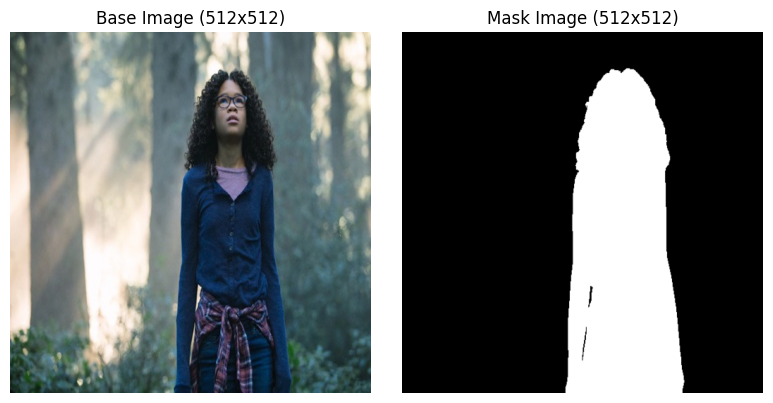

In [5]:
base_image = Image.open("/content/image.jpg").convert("RGB").resize((512, 512))
mask_image = Image.open("/content/mask.png").convert("L").resize((512, 512))

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(base_image)
axes[0].set_title("Base Image (512x512)")
axes[0].axis("off")

axes[1].imshow(mask_image, cmap="gray")
axes[1].set_title("Mask Image (512x512)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

### 🎨 Step 3: Inpaint the Masked Region

Use your inpainting pipeline to fill the masked region using a text prompt.

💬 Prompt idea: `"a futuristic object"` or `"a fantasy landscape"` (just an example)

Optional:
- Try different prompts to observe changes. (upto 3)
- comment on the guidance classifier value used and changes you observe.

Display the original and inpainted images together.


/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:242: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

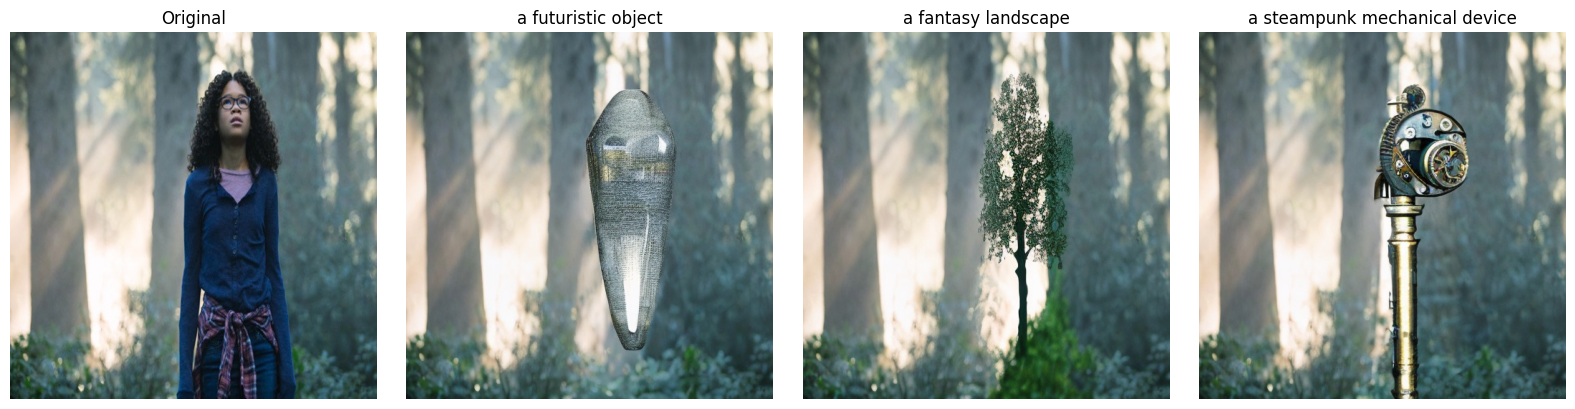

In [6]:
pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
)
pipe_inpaint = pipe_inpaint.to("cuda")
pipe_inpaint.safety_checker = None
pipe_inpaint.enable_attention_slicing()


base_image = Image.open("/content/image.jpg").convert("RGB").resize((512, 512))
mask_image = Image.open("/content/mask.png").convert("L").resize((512, 512))

prompts = [
    "a futuristic object",
    "a fantasy landscape",
    "a steampunk mechanical device"
]
guidance_scale = 7.5

inpainted_images = []
for prompt in prompts:
    result = pipe_inpaint(
        prompt=prompt,
        image=base_image,
        mask_image=mask_image,
        guidance_scale=guidance_scale,
        num_inference_steps=50
    )
    inpainted_images.append(result.images[0])

fig, axes = plt.subplots(1, len(prompts) + 1, figsize=(4 * (len(prompts) + 1), 4))
axes[0].imshow(base_image)
axes[0].set_title("Original")
axes[0].axis("off")

for i, img in enumerate(inpainted_images, start=1):
    axes[i].imshow(img)
    axes[i].set_title(prompts[i - 1])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# 🎨 Task 3: Style Transfer using ControlNet + IP-Adapter

## What is Style Transfer?

**Style Transfer** refers to the process of applying the artistic style of one image (e.g., a painting) to the content of another image (e.g., a photograph), generating a visually coherent blend of both.

In this task, we combine:
- **ControlNet** to preserve the structure or edges of the original image.
- **IP-Adapter** to influence the visual style using a reference (style) image.

This gives us fine-grained control over **what** the image contains (via prompts and edge maps) and **how** it looks (via the style image).

---

### 🔗 Required Models

You must load the following pre-trained models from Hugging Face:

- 🔧 **ControlNet Canny Detector**:  
  [lllyasviel/sd-controlnet-canny](https://huggingface.co/lllyasviel/sd-controlnet-canny)

- 🖼️ **Base Stable Diffusion Model (Absolute Reality)**:  
  [Yntec/AbsoluteReality](https://huggingface.co/Yntec/AbsoluteReality)

- 🎭 **IP Adapter Models** (for style transfer):  
  [h94/IP-Adapter](https://huggingface.co/h94/IP-Adapter)

You will use these models with `StableDiffusionControlNetPipeline` from the `diffusers` library.


# 🧪 Your Task

You will perform style transfer using ControlNet and an IP Adapter. Follow these steps:

---

### 🔹 Step 1: Load Models

Load the following using the appropriate functions:
- `ControlNetModel` for edge detection
- `StableDiffusionControlNetPipeline` as your generation pipeline
- Use `.load_ip_adapter()` to load the IP Adapter for style guidance

---

### 🔹 Step 2: Choose Images

- Select a **style image** (e.g., a painting, drawing, or themed artwork).
- Select a **base image** (e.g., a portrait or landscape).
- Resize the base image to `768x768` for consistent results.

---

### 🔹 Step 3: Generate Edge Map

Use the **CannyDetector** from `controlnet_aux` to extract edges from the base image.
This serves as the structural guide for generation.

---

### 🔹 Step 4: Define Your Prompt

Write a rich, descriptive prompt that communicates the **content** of your output (e.g., "girl in a red jacket standing in rain").

You may also use a `negative_prompt` like `"low quality"` to suppress undesired features.

---

### 🔹 Step 5: Generate Styled Images

Use the pipeline to generate new images, blending:
- Structure from the **edge map**
- Style from the **style image**
- Content from your **prompt**

---

### ✅ Requirements

- Generate at least **2 different sets** of images.
  - Each set should use a different **style image** and a different **base image**.
- For each set:



In [3]:
!pip install diffusers transformers accelerate safetensors xformers controlnet_aux

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

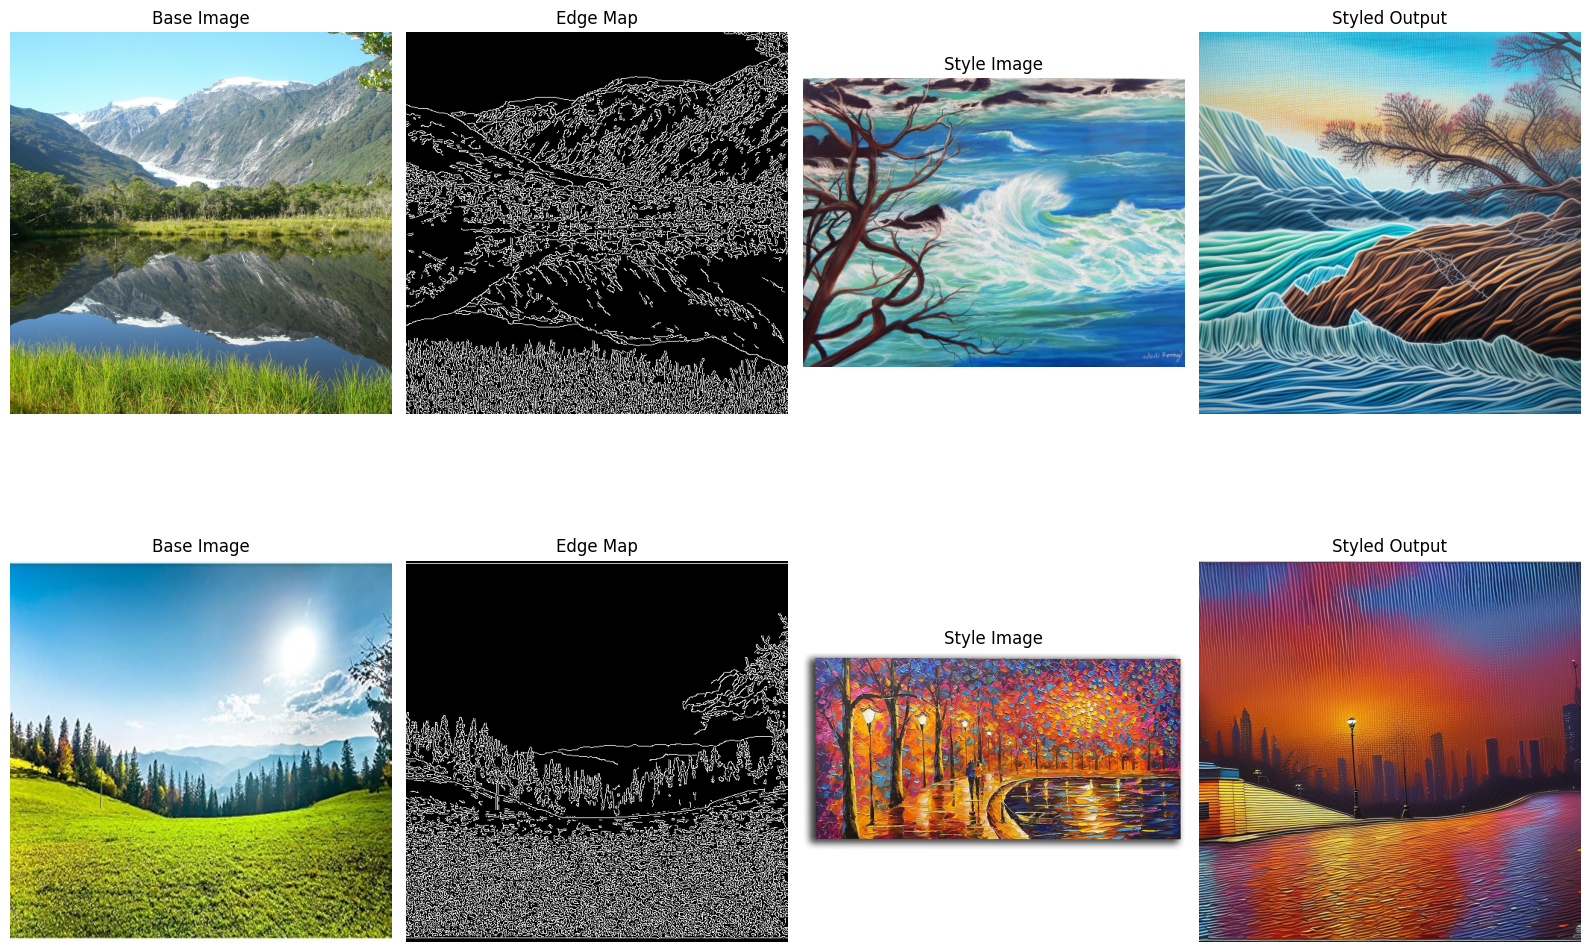

In [9]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from controlnet_aux import CannyDetector

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny",torch_dtype=torch.float16).to(device)
pipe = StableDiffusionControlNetPipeline.from_pretrained("Yntec/AbsoluteReality",controlnet=controlnet,torch_dtype=torch.float16).to(device)
pipe.safety_checker = None
pipe.load_ip_adapter("h94/IP-Adapter",subfolder="models",weight_name="ip-adapter_sd15.bin",)

canny = CannyDetector()
sets = [
    {
        "base_path":      "base1.jpg",
        "style_path":     "styled.jpg",
        "prompt":         "A mountain lake at sunrise, with mist rising off the water, in the style of a comic book panel",
        "negative_prompt": "low quality, blurry, oversaturated"
    },
    {
        "base_path":      "base2.jpg",
        "style_path":     "styled2.jpg",
        "prompt":         "futuristic city skyline at dusk, neon reflections on wet street, ultrawide vista",
        "negative_prompt": "low quality"
    },

]

fig, axes = plt.subplots(len(sets), 4, figsize=(16, 6 * len(sets)), squeeze=False)
for row, cfg in enumerate(sets):
    base  = Image.open(cfg["base_path"]).convert("RGB").resize((768, 768))
    style = Image.open(cfg["style_path"]).convert("RGB")
    edges = canny(base).convert("RGB")
    out = pipe(prompt=cfg["prompt"],negative_prompt=cfg["negative_prompt"],image=base,control_image=edges,ip_adapter_image=style,guidance_scale=7.5,num_inference_steps=50,)
    result = out.images[0]
    titles = ["Base Image", "Edge Map", "Style Image", "Styled Output"]
    for col, (ax, img, title) in enumerate(zip(axes[row], [base, edges, style, result], titles)):
        ax.imshow(img)
        ax.set_title(title, fontsize=12)
        ax.axis("off")
plt.tight_layout()
plt.show()